# Simple P300 classifier on open data

Recent neurotech developments like [Neuralink](https://www.neuralink.com/) and [FastMRI initiative](https://ai.facebook.com/blog/fastmri-releases-neuroimaging-data-set/) brings us to explore the current state of [Brain Computer Interfaces (BCI)](https://en.wikipedia.org/wiki/Brain%E2%80%93computer_interface) field as may be most of our communication with machines will occur only by thought very soon. The most straightforward and simple way to implement the BCI is to use [electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography) - just record electrical potential differences off the scalp and predict internal brain processes by using collected data.

To start with we rely on [P300 Event Related Potential (ERP)](https://en.wikipedia.org/wiki/P300_(neuroscience)) - kind of Evoked Potential (EP) that is related to decision making and stimuli discrimination. We visualize electroencephalogram (EEG) signal, explore ERP structure, build some classifiers and measure their performance.

There are plenty of tutorials on how to build a simple to moderate BCI solution as well as underlying brain mechanics explanation: [BCI2000](https://www.bci2000.org/mediawiki/index.php/User_Tutorial:Introduction_to_the_P300_Response), [Backyard Brains](https://backyardbrains.com/experiments/P300) articles and [Swartz Center video lectures](https://www.youtube.com/playlist?list=PLbbCsk7MUIGcO_lZMbyymWU2UezVHNaMq) to name a few (check them out). But all of them were made significant time ago and most of them use Matlab which nowadays is not widely used by Data Scientists, so we provide a tutorial relying on Python infrastructure.

All the code used in this post is [available in our repository](https://gitlab.com/impulse-neiry_public/posts).

To acquire BCI dataset you may call your friends, make a [VR game about Racoons and Demons](https://impulse-neiry.com/#rec124575598), record EEG of all your colleagues and write a scientific article about it (I'll tell you this story another time). Much easier way is to download existing open dataset previously recorded in a laboratory.

From Data Scientist point of view, P300 is just a surge in EEG at a certain time in certain brain areas. There are plenty of ways to trigger it, for example, if you concentrate on one stimulus and it gets activated (by changing the colour, shape, brightness or moving a bit) at a random moment. Here is the way this process was implemented at dawn of BCI:

[![P300 old interface](http://img.youtube.com/vi/wKDimrzvwYA/0.jpg)](https://www.youtube.com/watch?v=wKDimrzvwYA)

The general scheme is as follows: a person sees a few stimuli (usually from 3 to 7). He chooses one of them and focuses his attention on it (a good way to do it is to count activations) then stimuli get activated one by one in random order. Knowing activation time we could observe chunk of EEG right after the activation and guess if there was P300 present or not. As a person was focusing only on one particular stimulus, therefore there should be only one spike. Thus the current BCI is able to choose one of a few options (letters to spell, actions in a game, etc.). In case we have more than 7 options to choose from they are placed on a grid and choice is reduced to row+column choice. The video above shows the classical implementation of this approach called P300 speller that is used by paralyzed people to communicate.

A visual component used to record today's dataset was derived from a famous game [space invaders](https://en.wikipedia.org/wiki/Space_Invaders). The interface used to look like this

![Brain Inviders gameplay](images/brain_inviders.png)

In reality, it's the same P300 speller, with the only difference of letters being replaced by game aliens. Also, [gameplay video](https://www.youtube.com/watch?v=s73l8ZfQcWw) and [technical report](https://arxiv.org/ftp/arxiv/papers/1905/1905.05182.pdf) are available

All in all, we have the data that we can load from the Internet and it contains 16 channels of EEG and one channel of markers indicating starts of both target (chosen by the player) and empty (the rest) stimuli activations.

Most of BCI datasets were recorded by neurophysiologists and these guys usually don't care about compatibility thus formats are quite diverse: from different versions of `.mat` files to "standard" formats [`.edf`](https://en.wikipedia.org/wiki/European_Data_Format) and [`.gdf`](https://en.wikipedia.org/wiki/General_Data_Format_for_Biomedical_Signals). The main thing you need to know is that you don't want to parse all this on your own or work with it directly. Luckily a group of enthusiasts [NeuroTechX](https://neurotechx.com/) wrote loaders for some of the open datasets. These loaders are part of [moabb](https://github.com/NeuroTechX/moabb/) project claiming to standardize BCI solutions.


## Loading raw dataset

In [1]:
from pathlib import Path
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import moabb.datasets

In [2]:
matplotlib.style.use('seaborn')
plt.rcParams.update({'font.size': 15})

In [3]:
sampling_rate = 512

m_dataset = moabb.datasets.bi2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)

__Warning: loads ~7.5 Gb, you'll have to wait a while__

As of documentation `download` method have a parameter of loading path but it doesn't seem to work, so data will be unconditionally saved to `~/mne_data`

In [ ]:
m_dataset.download()

In [ ]:
m_data = m_dataset.get_data()

At this point, we acquired [RawEDF](https://mne.tools/stable/generated/mne.io.Raw.html) structure containing EEG recordings. This structure came from [`mne`](https://mne.tools/stable/index.html) package, it's usually utilized by biologists to process data: there are methods to filter, plot signals, store additional annotations and many more. But let’s not go this way, as the package interface is not stable and insufficiently documented (e.g. we use `0.17` package version instead of current `0.19` cause latest version fails to load our dataset).

What we take from mne package structure is channels labels in the [10-20 system](https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG)). This is an international system for electrode positioning on human head created to fix relations between brain zones and electrodes positions. Below you can see electrode positions in 10-10 system (higher density electrode settings compared to 10-20) and electrodes used in our dataset marked red.
![система 10-10](images/10-10_system.jpg)

In [6]:
print(m_data[1]['session_1']['run_1'])
channels = m_data[1]['session_1']['run_1'].ch_names[:-1]
channels

<RawEDF  |  1.gdf, n_channels x n_times : 17 x 159232 (311.0 sec), ~20.7 MB, data loaded>


['FP1',
 'FP2',
 'F5',
 'AFz',
 'F6',
 'T7',
 'Cz',
 'T8',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'Oz',
 'O2']

First for each participant we extract arrays of raw EEG 16 sec long and all marks (this is just another channel in signal)

At this stage, we preserve maximal length continuous signal to reduce edge effects on the filtering stage.

In [7]:
raw_dataset = []

for _, sessions in sorted(m_data.items()):
    eegs, markers = [], []
    for item, run in sorted(sessions['session_1'].items()):
        data = run.get_data()
        eegs.append(data[:-1])
        markers.append(data[-1])
    raw_dataset.append((eegs, markers))

In [8]:
raw_sample = raw_dataset[0][0][0]

In [9]:
len(raw_dataset), len(raw_dataset[0]), len(raw_dataset[0][0]), raw_dataset[0][0][0].shape

(24, 2, 4, (16, 159232))

We don't need moabb dataset anymore so we delete it to free memory

In [10]:
del m_data, m_dataset

## Filtering and epoch slicing

For in-depth overview of preprocessing and classification approaches I do recommend [excellent overview](https://iopscience.iop.org/article/10.1088/1741-2552/aab2f2) by neuroscience maîtres. Also, [another overview](https://iopscience.iop.org/article/10.1088/1741-2552/ab0ab5) of Deep Learning methods emerged this year. As follows from this works typical pipeline in the BCI field is

![typical eeg processing pipeline](images/eeg_pipeline.jpg)

The minimal pipeline includes three steps:
- decimation
- filtering
- scaling

We achieve this by using `sklearn` paradigm of Transformers and Pipelines to achieve extensibility. Custom transformers performing operations needed are implemented in `transformers.py` file then sampled into the pipeline.

__Decimation__
For some mystic reason, I've encountered in a number of articles decimation step performed by straightforward sample drop like `eeg = eeg[:, ::10]`. This is obviously incorrect so we use standard [`scipy` implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html) using anti-aliasing filter under the hood.

__Filtering__
Here we also use `scipy` filters. Particularly 4th order bandpass Butterworth filter applied forward and backward ([`filtfilt`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html)) resulting in 8th order filter without phase shift. Cut-off frequencies are 0.5-20 Hz which is a [standard approach](http://www.bbci.de/competition/iii/results/albany/AlainRakotomamonjy_desc.txt) for EEG filtering.

__Scaling__
We use channelwise `StandardScaler` (subtracts mean and divides by std) which fits to all the dataset. Actually, at this point, we introduce data leak, cause Scaler uses test data to fit its params but on a large enough datasets this effect is insignificant. Scaling is performed channelwise to preserve an ability to mix signals from different sources (and thus having different magnitudes) for example [electrodermal activity (EDA)](https://en.wikipedia.org/wiki/Electrodermal_activity).

For now, we don't make special filtering of artefacts like eye blinks or muscle contractions and leave this to our next article.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import transformers

In [12]:
reload(transformers)

decimation_factor = 10
final_rate = sampling_rate // decimation_factor
epoch_duration = 0.9 # seconds
labels_mapping = {33285.: 1, 33286.: 0}
captions = {0: 'empty', 1: 'target'}

eeg_pipe = make_pipeline(
    transformers.Decimator(decimation_factor),
    transformers.ButterFilter(sampling_rate // decimation_factor, 4, 0.5, 20),
    transformers.ChannellwiseScaler(StandardScaler()),
)
markers_pipe = transformers.MarkersTransformer(labels_mapping, decimation_factor)

After assembling our preprocessing pipeline we apply it to continuous EEG signal and slice it on so-called epochs. Epoch is a chunk of EEG in which specific brain processes start and finish (usually 0.5-2 seconds long) - in our case, it's the period of time from stimuli activation to 900 ms after. We could shrink epoch time to 600 ms for example but we preserved some margin just to be sure.

We have 16 channels and after applying decimation have 50 Hz signal rate thus one epoch is shaped `(16, 45)` cause it's 45 time samples during 900ms on 50 Hz.

Labels provided with this dataset are only binary - they denote starts of target (1) and empty (0) stimuli epochs.

In [13]:
for eegs, _ in raw_dataset:
    eeg_pipe.fit(eegs)

In [14]:
dataset = []
epoch_count = int(epoch_duration * final_rate)

for eegs, markers in raw_dataset:
    epochs = []
    labels = []
    filtered = eeg_pipe.transform(eegs)
    markups = markers_pipe.transform(markers)
    for signal, markup in zip(filtered, markups):
        epochs.extend([signal[:, start:(start + epoch_count)] for start in markup[:, 0]])
        labels.extend(markup[:, 1])
    dataset.append((np.array(epochs), np.array(labels)))

In [15]:
dataset[0][0].shape, dataset[0][0].dtype, dataset[0][1].shape

((1308, 16, 45), dtype('float64'), (1308,))

Eventually, we've made `Pytorch`-style dataset with each item storing one person’s game: preprocessed epochs and binary labels. We will use `Pytorch` facilities in later posts to train neural networks.

Using it we can test each person separately (for example make cross-validation) as well as test transfer (aka calibration-less or pre-trained) classifier.

At this point we don't need `raw_dataset` anymore, so delete it to free space

In [16]:
del raw_dataset

## Exploring and visualizing data

First, let's have a brief look on the filtered EEG data we've obtained.

Here is one continuous part of filtered EEG signal - it looks more or less like a noise.

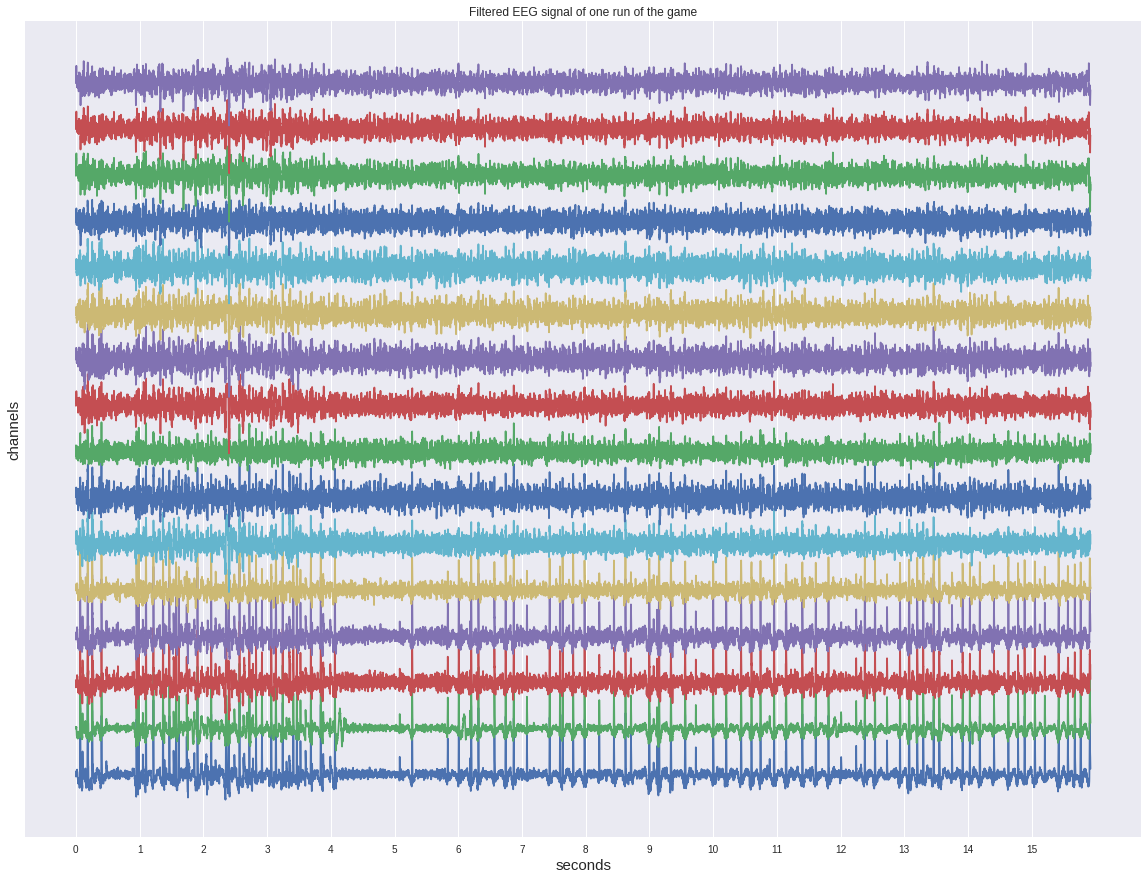

In [17]:
epoch = eeg_pipe.fit_transform([raw_sample])[0]
plt.figure(figsize=(20, 15))
plt.plot(epoch.T + np.arange(len(epoch))*5)
plt.yticks([])
plt.xticks(np.arange(0, 16000, 1000), np.arange(0, 32, 1))
plt.xlabel('seconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.title('Filtered EEG signal of one run of the game')
plt.show()

Now if we scale our view to one-second interval we see that signal has some structure - in this case some raise from 400 to 600 ms from epoch start. That is what we are searching for - an evoked P300 potential.

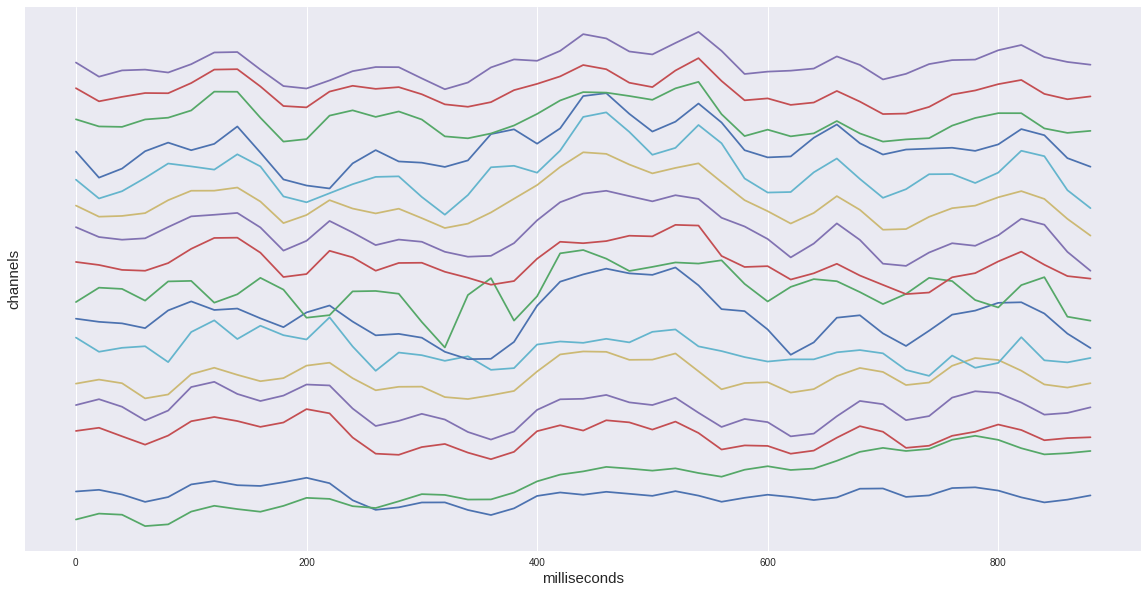

In [18]:
epoch = dataset[0][0][0]
plt.figure(figsize=(20, 10))
plt.plot(epoch.T + np.arange(len(epoch)))
plt.yticks([])
plt.xticks(np.arange(0, 50, 10), np.arange(0, 1000, 200))
plt.xlabel('milliseconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.show()

In [19]:
all_epochs = np.concatenate([epochs for epochs, _ in dataset])
all_epochs.shape, all_epochs.dtype

((34872, 16, 45), dtype('float64'))

We have about 35k epochs over all participants, with approximately 1300 to 1750 for each. This is caused by different success rate in killing aliens.
As it said in dataset announcement it has overall binary class ratio 1/5 because they used 6 by 6 table and every time only one of six stimuli was chosen. Later we'll return to that in metrics discussion.


5.0


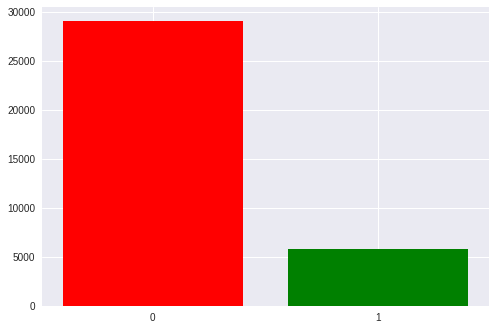

In [21]:
all_labels = np.concatenate([labels for _, labels in dataset])

uniques, counts = np.unique(all_labels, return_counts=True)

plt.bar(uniques, counts, color=['r', 'g'])
plt.xticks(uniques)

print(counts[0] / counts[1])

So class balance is not that good but it is exactly as promised

Now we could look at the target and non-target signals in general

In [22]:
def plot_by_labels(epochs, labels):
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    for label in (0, 1):
        mean = epochs[labels == label].mean(axis=(0, 1))
        std = epochs[labels == label].std(axis=(0, 1))

        axes[0].plot(mean, label=captions[label])

        axes[1].plot(mean, label=captions[label])
        axes[1].fill_between(np.arange(mean.size), mean-std, mean+std, alpha=0.25)

    axes[0].legend(fontsize=20)
    axes[0].set_ylim(-0.16, 0.26)
    axes[1].set_ylim(-0.8, 0.85)
    for i, title in enumerate(('Means', 'Means with Stds')):
        axes[i].set_title(title, fontsize=20)
        axes[i].set_xticklabels(np.arange(-200, 1000, 200))
        axes[i].set_xlabel('milliseconds')

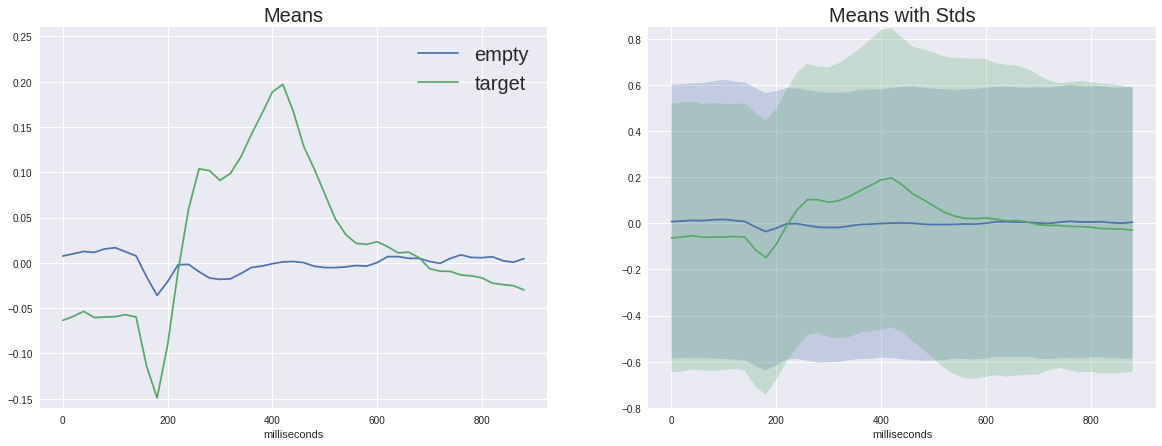

In [23]:
plot_by_labels(all_epochs, all_labels)

On the chart on the left, we can see that target stimulus gives more intensive mean response. Also, you can see non-specific response around 180ms in both signals but the target is stronger. Then the target has typical hump from 250 to 500ms that is proverbial P300 response.

With such a drastic contrast between signals one could consider classification task to be easy, but if we look at this chart with stds added we realize that both signals are quite noisy, so it's not that effortless.

(Actually, we haven’t been completely honest with the visualisation on these charts, as number of empty signals is 5 times bigger so it is averaged among bigger samples number and looks more smooth. But this doesn't help a lot cause stds have the same magnitudes)

In [24]:
plot_by_labels(dataset[6][0], dataset[6][1])

Furthermore, it's worth taking a look on average signals of one person.

Here we can see that both signals got more amplitude, this brings us to the previous remark on averaging, and as mentioned there - fewer samples mean more rough result.

Another meaningful characteristic is that particular person's P300 have a slightly different shape than the global average. Interpersonal variability of neurophysiological reactions is high, we will see this factor influence later at the classification stage. Although intrapersonal variability is high too and depends on the stress level, mood, fatigue, etc.

In [25]:
import visualizers

Subtracting Evoked from Epochs
[done]


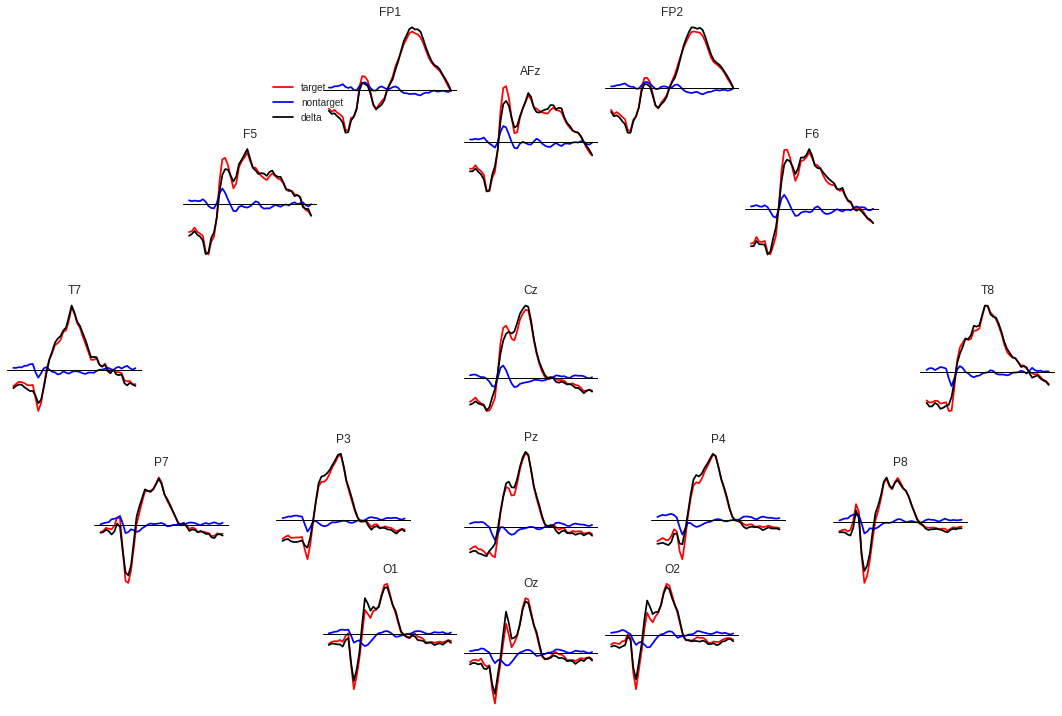

In [26]:
reload(visualizers)

visualizers.plot_evoked_electrodes(dataset, final_rate, channels)

Here we can see channelwise signals. Places of signals correspond 10-10 system highlights demonstrated above.

We can see how response changes with the electrodes’ position on the scalp. For example in `Fp1`, `Fp2` channels, two negative peaks are clearly expressed before positive. Also, some channels have two distinct positive peaks, others have only one and something in between for the rest of channels.

Different electrodes capture different parts of response and contribute differently to prediction quality - we will measure it in later posts using mutual information and stepwise regression.

Having enough electrodes one could even interpolate potentials on the whole head and plot voltage map at any moment. For 16 electrodes this map is barely accurate but it gives a qualitative understanding of process occurring. Note that `mne` by default expects signal to be measured in volts but we've already applied scaling so now absolute values of the signal aren’t meaningful.

Subtracting Evoked from Epochs
[done]


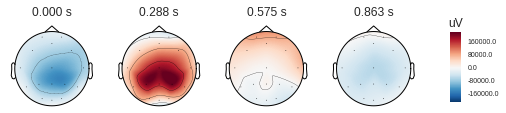

In [27]:
reload(visualizers)

visualizers.plot_evoked_map(dataset, final_rate, channels)

Subtracting Evoked from Epochs
[done]


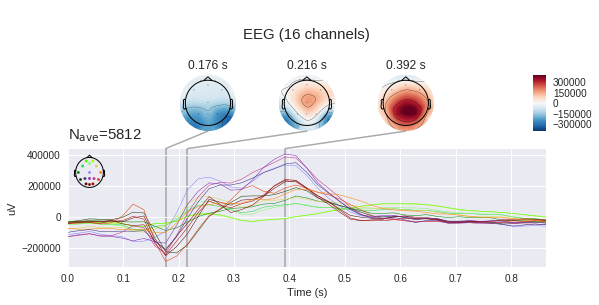

In [28]:
reload(visualizers)
    
visualizers.plot_evoked_joint(dataset, final_rate, channels)

## Classification

Further on, it's time to apply some ML techniques to our data to solve the main problem of selected stimulus discrimination.

Classifiers we use are Logistic Regression, SVM and some other techniques based on ERP specific correlation analysis taken from [`pyriemann`](https://github.com/alexandrebarachant/pyRiemann) package. Details of these methods can be clarified in packages documentation and papers, one thing to note is that [several](https://www.kaggle.com/c/inria-bci-challenge/discussion/12819#latest-91984) [competitions](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/discussion/16479#latest-165271) winning solutions are using them.

In [43]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from mne.decoding import Vectorizer, CSP

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

In [30]:
scores = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

In [31]:
# from https://eeg-notebooks.readthedocs.io/en/latest/visual_p300.html
# and https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html

clfs = {
    'LR': (
        make_pipeline(Vectorizer(), LogisticRegression()),
        {'logisticregression__C': np.exp(np.linspace(-4, 4, 5))},
    ),
    'LDA': (
        make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen')),
        {},
    ),
    'SVM': (
        make_pipeline(Vectorizer(), SVC()),
        {'svc__C': np.exp(np.linspace(-4, 4, 5)), 'svc__kernel': ('linear', 'rbf')},
    ),
    'CSP LDA': (
        make_pipeline(CSP(), LDA(shrinkage='auto', solver='eigen')),
        {'csp__n_components': (6, 9, 13), 'csp__cov_est': ('concat', 'epoch')},
    ),
    'Xdawn LDA': (
        make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen')),
        {},
    ),
    'ERPCov TS LR': (
        make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression()),
        {'erpcovariances__estimator': ('lwf', 'oas')},
    ),
    'ERPCov MDM': (
        make_pipeline(ERPCovariances(), MDM()),
        {'erpcovariances__estimator': ('lwf', 'oas')},
    ),
}

In [39]:
def crossvalidate_record(record, clfs=clfs, scores=scores):
    df = pd.DataFrame()
    for name, (clf, params) in clfs.items():
        cv = GridSearchCV(
            clf,
            params,
            scoring=scores,
            n_jobs=-1,
            iid=False,
            refit=False,
            cv=4,
        )
        cv.fit(record[0], record[1])
        headers = [
            name for name in cv.cv_results_.keys()
                if name.startswith('param_') or name.startswith('mean_test_') or name.startswith('std_test_')
        ]
        results = pd.DataFrame(cv.cv_results_)[headers]
        results['cassifier'] = name
        df = pd.concat((df, results), sort=False)
    return df.reindex(sorted(df.columns), axis=1)

In [40]:
crossvalidate_record(dataset[0]).sort_values('mean_test_f1', ascending=False)

cassifier  mean_test_accuracy  mean_test_f1  mean_test_precision  \
0           LDA            0.958720      0.869982             0.912620   
6            LR            0.954128      0.858877             0.884439   
5            LR            0.954128      0.858276             0.888814   
7            LR            0.953356      0.855507             0.883596   
4            LR            0.953366      0.854803             0.890379   
3            LR            0.953361      0.854762             0.888503   
8            LR            0.952590      0.854107             0.876278   
0     Xdawn LDA            0.948002      0.836727             0.876971   
2            LR            0.947254      0.832824             0.882602   
0  ERPCov TS LR            0.946469      0.831684             0.871476   
1  ERPCov TS LR            0.946473      0.831500             0.871176   
1            LR            0.941133      0.811995             0.870007   
0            LR            0.934245      0.791300             0.845541   
8           SVM            0.931173      0.770318             0.866680   
7           SVM            0.931173      0.770318             0.866680   
6           SVM            0.924309      0.746643             0.848961   
5           SVM            0.920470      0.718128             0.875196   
4           SVM            0.894471      0.575951             0.869081   
1    ERPCov MDM            0.741592      0.347536             0.305249   
0    ERPCov MDM            0.741607      0.333527             0.294201   
3           SVM            0.856244      0.287582             0.850000   
2       CSP LDA            0.808909      0.161254             0.467470   
5       CSP LDA            0.808909      0.161254             0.467470   
1       CSP LDA            0.808137      0.139796             0.377976   
4       CSP LDA            0.808137      0.139796             0.377976   
0       CSP LDA            0.809690      0.113778             0.506604   
3       CSP LDA            0.809690      0.113778             0.506604   
2           SVM            0.834870      0.033333             0.166667   
1           SVM            0.833336      0.000000             0.000000   
0           SVM            0.833336      0.000000             0.000000   

   mean_test_recall  mean_test_roc_auc param_csp__cov_est  \
0          0.834764           0.978623                NaN   
6          0.839141           0.967125                NaN   
5          0.834596           0.967563                NaN   
7          0.834428           0.966684                NaN   
4          0.825505           0.967500                NaN   
3          0.825589           0.966568                NaN   
8          0.838973           0.966246                NaN   
0          0.802609           0.976279                NaN   
2          0.793434           0.964386                NaN   
0          0.797980           0.977800                NaN   
1          0.798064           0.977985                NaN   
1          0.765825           0.959849                NaN   
0          0.747475           0.949953                NaN   
8          0.696801           0.959767                NaN   
7          0.696801           0.959767                NaN   
6          0.669613           0.958261                NaN   
5          0.609764           0.950098                NaN   
4          0.430892           0.931655                NaN   
1          0.412542           0.752976                NaN   
0          0.394444           0.735645                NaN   
3          0.174158           0.914839                NaN   
2          0.123401           0.701354             concat   
5          0.123401           0.701354              epoch   
1          0.104966           0.703882             concat   
4          0.104966           0.703882              epoch   
0          0.086785           0.698181             concat   
3          0.086785           0.698181              epoch   
2  

The most popular neurointerface scheme is "calibration+prediction". Calibration means that person has to provide some data samples with known labels, usually subject is told to focus on pointed stimulus for some time. Then this data is used to train the classifier and only after that system is able to predict person's choices. This approach has an obvious disadvantage of need to stare at predefined objects. This is not a problem for medical usage but can be fatal to gameplay experience.

To test our classifiers in this mode let's perform cross-validation over one subject’s epochs. Accuracy metric is insufficient in this case due to an unbalanced dataset (constant predictions baseline is 5/6 ~ 83%), so I prefer to keep track of triplet precision-recall-f1.

To observe performance on the whole dataset we average cross-validation score of every person. In general best models’ results are high enough compared with what we have at [Neiry](https://impulse-neiry.com/) "in the field" (note that this dataset was recorded in a lab).

Returning to initial task one could wonder how to answer the final question of multiclass stimulus choice task (by the way it is balanced). To solve it a number of activations gets fixed (for example 5 activations of 6 stimuli) and all stimuli get activated in random order. Then we acquire 30 epochs and for each stimulus probabilities of its epochs to be target are summed. Stimulus with maximum score is acknowledged as a target. We will implement this approach in one of our future posts on sufficient dataset cause this one has only binary labels.

In [41]:
def crossvalidate_dataset(dataset, clfs=clfs, scores=scores):
    res = {name: [] for name in scores}
    for record in dataset:
        df = crossvalidate_record(record, clfs, scores)
        for name in scores:
            res[name].append(df[f'mean_test_{name}'])

    final = df.copy()
    for name, values in res.items():
        values = np.array(values)
        final[f'mean_test_{name}'] = values.mean(axis=0)
        final[f'std_test_{name}'] = values.std(axis=0)
    return final.sort_values('mean_test_f1', ascending=False)

In [42]:
crossvalidate_dataset(dataset)

cassifier  mean_test_accuracy  mean_test_f1  mean_test_precision  \
0           LDA            0.923740      0.755187             0.807938   
0     Xdawn LDA            0.916701      0.724430             0.789652   
1  ERPCov TS LR            0.915442      0.717535             0.803442   
4            LR            0.908585      0.714396             0.749877   
3            LR            0.910585      0.713458             0.766201   
0  ERPCov TS LR            0.914804      0.712915             0.802924   
5            LR            0.905771      0.709680             0.735692   
2            LR            0.911547      0.706163             0.783485   
6            LR            0.902927      0.704557             0.722633   
7            LR            0.901106      0.701588             0.713840   
8            LR            0.899919      0.699559             0.707851   
8           SVM            0.908244      0.685758             0.781939   
7           SVM            0.908588      0.683970             0.788436   
1            LR            0.907498      0.681123             0.786771   
6           SVM            0.906439      0.656717             0.811615   
0            LR            0.896447      0.632473             0.761024   
5           SVM            0.890994      0.532397             0.848811   
1    ERPCov MDM            0.763964      0.481565             0.405714   
0    ERPCov MDM            0.757199      0.466557             0.388717   
4           SVM            0.859632      0.251390             0.708445   
2       CSP LDA            0.821695      0.085226             0.268434   
5       CSP LDA            0.821695      0.085226             0.268434   
1       CSP LDA            0.822140      0.076562             0.273813   
4       CSP LDA            0.822140      0.076562             0.273813   
0       CSP LDA            0.821165      0.066532             0.214891   
3       CSP LDA            0.821165      0.066532             0.214891   
3           SVM            0.835943      0.030293             0.132961   
2           SVM            0.833398      0.001389             0.006944   
1           SVM            0.833334      0.000000             0.000000   
0           SVM            0.833334      0.000000             0.000000   

   mean_test_recall  mean_test_roc_auc param_csp__cov_est  \
0          0.714048           0.937733                NaN   
0          0.675967           0.929576                NaN   
1          0.656063           0.934828                NaN   
4          0.688541           0.925202                NaN   
3          0.674487           0.927167                NaN   
0          0.648123           0.933822                NaN   
5          0.691252           0.922693                NaN   
2          0.651868           0.926304                NaN   
6          0.692869           0.920636                NaN   
7          0.695245           0.918897                NaN   
8          0.697037           0.917520                NaN   
8          0.618254           0.919802                NaN   
7          0.612159           0.921595                NaN   
1          0.612840           0.919736                NaN   
6          0.563565           0.921394                NaN   
0          0.558913           0.904283                NaN   
5          0.416425           0.912578                NaN   
1          0.636757           0.812373                NaN   
0          0.623384           0.796542                NaN   
4          0.175679           0.901455                NaN   
2          0.056926           0.636041             concat   
5          0.056926           0.636041              epoch   
1          0.050991           0.637505             concat   
4          0.050991           0.637505              epoch   
0          0.045761           0.638442             concat   
3          0.045761           0.638442              epoch   
3          0.017866           0.898745                NaN   
2  

The second scheme of prediction is called transfer learning which means predicting epochs of unknown people. The thing is when we train only on one person's epochs, in fact, we overfit to particular peak form thus the prediction of this kind of peaks have relatively good quality but this classifier doesn't recognize general P300 concept.

We conduct two experiments - train one classifier on one person and predict different five, then increase training set to 10 persons (different than testing five) to ensure an increase of prediction ability.

In [56]:
def transfer_validate(train_records: list, val_records: list, clfs=clfs, scores=scores):
    df = pd.DataFrame()
    
    train_epochs = np.concatenate([epochs for epochs, _ in train_records])
    train_labels = np.concatenate([labels for _, labels in train_records])
    val_epochs = np.concatenate([epochs for epochs, _ in val_records])
    val_labels = np.concatenate([labels for _, labels in val_records])
    splitter = PredefinedSplit([-1] * len(train_labels) + [0] * len(val_labels))
    epochs = np.concatenate((train_epochs, val_epochs))
    labels = np.concatenate((train_labels, val_labels))

    for name, (clf, params) in clfs.items():
        cv = GridSearchCV(
            clf,
            params,
            scoring=scores,
            n_jobs=-1,
            iid=False,
            refit=False,
            cv=splitter,
        )
        cv.fit(epochs, labels)
        headers = [
            name for name in cv.cv_results_.keys()
                if name.startswith('param_') or name.startswith('mean_test_') or name.startswith('std_test_')
        ]
        results = pd.DataFrame(cv.cv_results_)[headers]
        results['cassifier'] = name
        df = pd.concat((df, results), sort=False)
    return df.reindex(sorted(df.columns), axis=1)

In [58]:
transfer_validate(dataset[:1], dataset[10:15])

cassifier  mean_test_accuracy  mean_test_f1  mean_test_precision  \
0            LR            0.834426      0.233881             0.511050   
1            LR            0.835656      0.212181             0.527687   
2            LR            0.836749      0.203864             0.544484   
3            LR            0.835519      0.201592             0.527778   
4            LR            0.835656      0.209073             0.528239   
5            LR            0.835383      0.213960             0.523962   
6            LR            0.833880      0.210390             0.506250   
7            LR            0.833333      0.212903             0.500000   
8            LR            0.832104      0.210662             0.486647   
0           LDA            0.840984      0.195021             0.623894   
0           SVM            0.833333      0.000000             0.000000   
1           SVM            0.833333      0.000000             0.000000   
2           SVM            0.833333      0.000000             0.000000   
3           SVM            0.833743      0.019339             0.571429   
4           SVM            0.836475      0.104712             0.598291   
5           SVM            0.837978      0.139332             0.607595   
6           SVM            0.838388      0.162774             0.595855   
7           SVM            0.838115      0.168421             0.585366   
8           SVM            0.838115      0.168421             0.585366   
0       CSP LDA            0.809426      0.060606             0.169811   
1       CSP LDA            0.810519      0.067249             0.187266   
2       CSP LDA            0.807104      0.068602             0.175676   
3       CSP LDA            0.809426      0.060606             0.169811   
4       CSP LDA            0.810519      0.067249             0.187266   
5       CSP LDA            0.807104      0.068602             0.175676   
0     Xdawn LDA            0.841667      0.194580             0.639269   
0  ERPCov TS LR            0.839754      0.151844             0.644172   
1  ERPCov TS LR            0.837978      0.157670             0.590426   
0    ERPCov MDM            0.789754      0.118052             0.196190   
1    ERPCov MDM            0.786475      0.116450             0.187614   

   mean_test_recall  mean_test_roc_auc param_csp__cov_est  \
0          0.151639           0.711602                NaN   
1          0.132787           0.719348                NaN   
2          0.125410           0.721404                NaN   
3          0.124590           0.719455                NaN   
4          0.130328           0.716132                NaN   
5          0.134426           0.712814                NaN   
6          0.132787           0.710186                NaN   
7          0.135246           0.708162                NaN   
8          0.134426           0.706610                NaN   
0          0.115574           0.754377                NaN   
0          0.000000           0.720534                NaN   
1          0.000000           0.720601                NaN   
2          0.000000           0.720589                NaN   
3          0.009836           0.725641                NaN   
4          0.057377           0.734433                NaN   
5          0.078689           0.739803                NaN   
6          0.094262           0.730147                NaN   
7          0.098361           0.727328                NaN   
8          0.098361           0.727328                NaN   
0          0.036885           0.561868             concat   
1          0.040984           0.548830             concat   
2          0.042623           0.552754             concat   
3          0.036885           0.561868              epoch   
4          0.040984           0.548830              epoch   
5          0.042623           0.552754              epoch   
0          0.114754           0.787763                NaN   
0          0.086066           0.771277                NaN   
1  

In [59]:
transfer_validate(dataset[:10], dataset[10:15])

cassifier  mean_test_accuracy  mean_test_f1  mean_test_precision  \
0            LR            0.861885      0.400711             0.723769   
1            LR            0.866393      0.438576             0.731801   
2            LR            0.867760      0.458613             0.721831   
3            LR            0.867896      0.465451             0.714771   
4            LR            0.866530      0.465244             0.700165   
5            LR            0.866940      0.467760             0.701639   
6            LR            0.866940      0.468341             0.700980   
7            LR            0.866393      0.467320             0.696429   
8            LR            0.866393      0.467320             0.696429   
0           LDA            0.869262      0.458404             0.740402   
0           SVM            0.833333      0.000000             0.000000   
1           SVM            0.833333      0.000000             0.000000   
2           SVM            0.833333      0.000000             0.000000   
3           SVM            0.836339      0.036977             0.958333   
4           SVM            0.851639      0.259209             0.772358   
5           SVM            0.862432      0.378011             0.766917   
6           SVM            0.869399      0.462921             0.735714   
7           SVM            0.871995      0.519241             0.694102   
8           SVM            0.867213      0.529981             0.646226   
0       CSP LDA            0.830191      0.009562             0.171429   
1       CSP LDA            0.830191      0.007981             0.151515   
2       CSP LDA            0.828825      0.011050             0.148936   
3       CSP LDA            0.830191      0.009562             0.171429   
4       CSP LDA            0.830191      0.007981             0.151515   
5       CSP LDA            0.828825      0.011050             0.148936   
0     Xdawn LDA            0.855601      0.368201             0.679912   
0  ERPCov TS LR            0.876776      0.545363             0.708115   
1  ERPCov TS LR            0.876776      0.544904             0.708661   
0    ERPCov MDM            0.750820      0.187166             0.205078   
1    ERPCov MDM            0.740164      0.209476             0.212479   

   mean_test_recall  mean_test_roc_auc param_csp__cov_est  \
0          0.277049           0.842113                NaN   
1          0.313115           0.846606                NaN   
2          0.336066           0.847314                NaN   
3          0.345082           0.846306                NaN   
4          0.348361           0.845156                NaN   
5          0.350820           0.844264                NaN   
6          0.351639           0.843696                NaN   
7          0.351639           0.843334                NaN   
8          0.351639           0.843084                NaN   
0          0.331967           0.852494                NaN   
0          0.000000           0.838087                NaN   
1          0.000000           0.838003                NaN   
2          0.000000           0.838023                NaN   
3          0.018852           0.839495                NaN   
4          0.155738           0.848519                NaN   
5          0.250820           0.855706                NaN   
6          0.337705           0.854544                NaN   
7          0.414754           0.845919                NaN   
8          0.449180           0.829630                NaN   
0          0.004918           0.571894             concat   
1          0.004098           0.569111             concat   
2          0.005738           0.569092             concat   
3          0.004918           0.571894              epoch   
4          0.004098           0.569111              epoch   
5          0.005738           0.569092              epoch   
0          0.252459           0.846817                NaN   
0          0.443443           0.863286                NaN   
1  

So f1 increased 0.23 to 0.4 for the best classifier (in both cases it happened to be Logistic Regression with the same regularization term).

This means prediction ability increased from unsatisfying to acceptable. On the basis of our experience classifiers of this quality may result in multiclass task accuracy around 75%.

Finally, note that this example is a bit primitive that could be ensured by a high level of regularization in Logistic Regression - channels are strongly correlated (this issue may be solved for example with embeddings).

## Conclusion

Today we've observed P300 evoked potential and assembled simple pipeline for neuro interface. I recommend to checkout notebook with code yourself (it's available at our [repository](https://gitlab.com/impulse-neiry_public/posts)) and experiment with visualizations and classifiers.

Having a basic knowledge of EEG signal processing methods we will be able to examine this field in depth in later posts: advanced preprocessing methods and plenty of neural network architectures. To be continued...